# PROJECT NAME

---
## Import Relevant Libraries
---

In [54]:
import os.path
import time
import glob
import json
import copy

from fileMaster import *

import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree
from matplotlib.colors import ListedColormap, to_rgb

import tensorflow as tf

import tqdm

-----
## Preliminary Cleaning | Clean ill-formated Data
-----

In [55]:
with open(raw_data_txt, 'r', encoding='utf-8') as f:
    raw_lines = f.readlines()

df = pd.DataFrame(columns=['Type', 'Msg'])

count = 0

for line in raw_lines:
    # Encode Sensitive Info
    line = line.replace("&lt;#&gt;", "[NUM]").replace(" [NUM] ", "[NUM]")
    line = line.replace("&lt;DECIMAL&gt;", "[DEC]").replace(" [DEC] ", "[DEC]")
    line = line.replace("&lt;URL&gt;", "[URL]").replace(" [URL] ", "[URL]")
    line = line.replace("&lt;TIME&gt;", "[TIME]").replace(" [URL] ", "[URL]")
    line = line.replace("&lt;EMAIL&gt;", "[EMAIL]").replace(" [EMAIL] ", "[EMAIL]")

    # Replace Known Strings
    line = line.replace("&lt;3", "[HEART]").replace(" [HEART] ", "[HEART]")
    line = line.replace("&lt;", "<")
    line = line.replace("&gt;", ">")
    line = line.replace("&amp;", "&")

    # Replace Special Characters
    line = line.replace("\x92", "'")
    line = line.replace("Bill said u or ur rents", 'Bill said u or ur parents')
    line = line.replace("MORROW", "TOMORROW")
    line = line.replace(" ", "")
    line = line.replace("ü", "u")
    line = line.replace("Ü", "U")
    line = line.replace("", "")
    line = line.replace("", " ")

    # Replace Unknown Characters
    line = line.replace("鈥┾??〨ud", "[UNK]")

    _lst = line.split('\t')
    _type = _lst[0]
    _msg = _lst[1].strip()

    d = {'Type': _type, 'Msg': _msg}
    df2 = pd.DataFrame(d, [count])

    df = pd.concat([df, df2], axis=0)

    count += 1

df.to_csv(cleaned_data_csv, sep=',', encoding='utf-8', index=False)

In [56]:
df.head()

,Type,Msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


---
## Verify Tensorflow GPU is Identified
---

In [57]:
if tf.test.gpu_device_name():

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


---
## Exploratory Data Analysis
---

### <blockquote>Basic Statistics

In [58]:
df.groupby("Type").describe()

Msg                                                               
     count unique                                                top freq
Type                                                                     
ham   4827   4518                             Sorry, I'll call later   30
spam   747    642  Please call our customer service representativ...    4

In [59]:
eda_type_count_df = pd.DataFrame({'Count': [df['Type'].value_counts()['ham'], df['Type'].value_counts()['spam']], 'Type': ['Ham', 'Spam']}, ['Ham', 'Spam'])
eda_type_count_fig = px.bar(eda_type_count_df, x='Type', y='Count', orientation='v', color_discrete_sequence=["#A0e7A0", "#FF8986"], color='Type', title='Count of Message Types', text_auto='', template='plotly')
eda_type_count_fig.show()

The number of datapoints is skewed heavily in favor of Ham messages. This is unsurprising, given that on a daily basis most people receive more ham than spam. However, this may lead to potential implicit biasness in our models. Hence, we will be using our models on a balanced dataset and the original to determine the effects of such a skew.

### <blockquote>Tokenization

In [60]:
def tokenization(msg, punc_remove=False):
    punct_lst = ['...', '..', ",", '.', ';', '<', '>', '/', '"', '&', '!', '@', '#', '?', ]

    strng = msg

    for p in punct_lst:

        if ('..'  in strng or '...' in strng) and p == '.':
            pass
        else:
            temp_lst = strng.split(p)
            temp_lst = [x.rstrip() for x in temp_lst]
            temp_lst = [x.lstrip() for x in temp_lst]

            if punc_remove:
                strng = f' '.join(temp_lst)
            else:
                strng = f' {p} '.join(temp_lst)

    word_lst = strng.split(' ')

    if not punc_remove:
        count = 0

        punct_lst.remove('..')
        punct_lst.remove('...')

        for w in word_lst:
            try:
                for p in punct_lst:
                    if  w == 2*p and word_lst[count+1] == p:
                        word_lst[count] = 3*p
                        word_lst.pop(count + 1)
            except IndexError:  
                '''
                Index error occurs when we are at the last element of list and 
                try to access the next element, this means that the ".." is at the 
                last element so we do not to do anything abt it
                '''
                pass

            count += 1

    return word_lst

Above is our own rules-based function to tokenize the words in the messages.

In [61]:
def split_sentence(msg):
    punct_lst = ['...', '..', '.', '?', '!', ';']

    strng = msg

    for p in punct_lst:

        if ('..'  in strng or '...' in strng) and p == '.':
            pass
        else:
            temp_lst = strng.split(p)
            temp_lst = [x.rstrip() for x in temp_lst]
            temp_lst = [x.lstrip() for x in temp_lst]
            strng = f'|'.join(temp_lst)

    sentence_lst = strng.split('|')

    sym_lst = ['...', '..', ",", '.', ';', '<', '>', '/', '"', '&', '!', '@', '#', '?', ' ', '']
    for s in sentence_lst:
        if s in sym_lst:
            sentence_lst.remove(s)

    return sentence_lst

Above is our own rules-based function to tokenize the sentences in the messages.

In [62]:
# Tokenize Characters
df['CharCount'] = df['Msg'].apply(lambda x: len(x))

# Tokenize Words
df['ListWords'] = df['Msg'].apply(lambda x: tokenization(x))
df['NumWords'] = df['Msg'].apply(lambda x: len(tokenization(x, punc_remove=True)))

# Tokenize Sentences
df['ListSentence'] = df['Msg'].apply(lambda x: split_sentence(x))
df['NumSentences'] = df['Msg'].apply(lambda x: len(split_sentence(x)))

In [63]:
df.head()

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point, ,, crazy, .., Avail...",20,"[Go until jurong point, crazy, Available only ...",3
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]",6,"[Ok lar, Joking wif u oni]",2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",29,[Free entry in 2 a wkly comp to win FA Cup fin...,2
3,ham,U dun say so early hor... U c already then say...,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...",11,"[U dun say so early hor, U c already then say]",2
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, don't, think, he, goes, to, usf, ,, h...",13,"[Nah I don't think he goes to usf, he lives ar...",1


First 5 messages and their character, words and sentences tokenized and counted.

In [64]:
df.tail()

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences
5569,spam,This is the 2nd time we have tried 2 contact u...,160,"[This, is, the, 2nd, time, we, have, tried, 2,...",30,[This is the 2nd time we have tried 2 contact ...,5
5570,ham,Will u b going to esplanade fr home?,36,"[Will, u, b, going, to, esplanade, fr, home, ?, ]",9,[Will u b going to esplanade fr home],1
5571,ham,"Pity, * was in mood for that. So...any other s...",57,"[Pity, ,, *, was, in, mood, for, that., So, .....",12,"[Pity, * was in mood for that, So, any other s...",3
5572,ham,The guy did some bitching but I acted like i'd...,125,"[The, guy, did, some, bitching, but, I, acted,...",26,[The guy did some bitching but I acted like i'...,1
5573,ham,Rofl. Its true to its name,26,"[Rofl, ., Its, true, to, its, name]",6,"[Rofl, Its true to its name]",2


Last 5 messages and their character, words and sentences tokenized and counted.

### <blockquote> Histograms of *CharCount*, *NumWords*, *NumSentence*

In [65]:
eda_charc_hist = px.histogram(df[['CharCount', 'Type']], 
                              x='CharCount', 
                              color='Type', 
                              template='plotly', 
                              title='Histogram on Number of Characters', 
                              color_discrete_sequence=["#A0e7A0", "#FF8986"])
eda_charc_hist.update_layout(barmode='overlay')

It is interesting note that most **spam** messages have a **higher** character count (i.e. the mode of spam messages lies between 155-159 characters) than ham messages (i.e. mode of ham messages lies between 25-29 characters). Furthermore, the distribution of ham messages is **positively** skewed, whereas that of spam messages is **negatively** skewed.

In [66]:
eda_charc_hist = px.histogram(df[['NumWords', 'Type']], 
                              x='NumWords', 
                              color='Type', 
                              template='plotly', 
                              title='Histogram on Number of Words', 
                              color_discrete_sequence=["#A0e7A0", "#FF8986"])
eda_charc_hist.update_layout(barmode='overlay')

It is interesting note that most **spam** messages have a **higher** word count (i.e. the mode of spam messages lies at 28 words) than ham messages (i.e. mode of ham messages lies at 6 words). Furthermore, the two distributions of CharCount and NumWords look fairly similar in shape. Hence, the distribution of ham messages is still **positively** skewed, whereas that of spam messages is still **negatively** skewed.

In [67]:
eda_charc_hist = px.histogram(df[['NumSentences', 'Type']], 
                              x='NumSentences', 
                              color='Type', 
                              template='plotly', 
                              title='Histogram on Number of Sentences', 
                              color_discrete_sequence=["#A0e7A0", "#FF8986"])
eda_charc_hist.update_layout(barmode='overlay')

**Visually**, it is interesting to note that the **distribution** of **spam** messages **seem to follow a Normal Distribution**, with the mode of **spam** messages being at 3, which is significantly higher than that of **ham** messages (whose mode lies at 1 sentence). It is also unsurprising that the distribution of **ham** messages have a **positive** skew, considering that most people will limit their text to around a sentence in this day and age. Hence, our group postulates that, **ceteris paribus**, the **likelihood** of a message being a **spam** message is high should there be 3-4 sentences.

### <blockquote> Box-Plots of *CharCount*, *NumWords*, *NumSentence*

In [68]:
def genBoxPlot(var):
    box_fig = go.Figure()
    box_fig.layout.title = f'Box-Plots of Spam and Ham for {var}'
    ham_df = df[df['Type']=='ham']
    temp_df = df

    temp_df['Ham'] = ham_df[var]
    spam_df = df[df['Type']=='spam']
    temp_df['Spam'] = spam_df[var]


    for col in temp_df[['Ham', 'Spam']]:
        box_fig.add_trace(
            go.Box(x=temp_df[col].values,
                   name=temp_df[col].name,
                   fillcolor=["#CEF3CE", "#FFEBEB"][['Ham', 'Spam'].index(col)],
                   line={'color': ["#6BDB6B", "#FF8986"][['Ham', 'Spam'].index(col)]}
                   )
        )
    box_fig.update_traces(orientation='h')
    box_fig.show()
    return temp_df

Above is our own function to generate the box-plots for the various types of counts and their type of message.

In [69]:
# Call function to generate Box-Plots for CharCount, NumWords and NumSentences

genBoxPlot('CharCount')
genBoxPlot('NumWords')
genBoxPlot('NumSentences')

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences,Ham,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point, ,, crazy, .., Avail...",20,"[Go until jurong point, crazy, Available only ...",3,3.0,NaN
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]",6,"[Ok lar, Joking wif u oni]",2,2.0,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",29,[Free entry in 2 a wkly comp to win FA Cup fin...,2,NaN,2.0
3,ham,U dun say so early hor... U c already then say...,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...",11,"[U dun say so early hor, U c already then say]",2,2.0,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, don't, think, he, goes, to, usf, ,, h...",13,"[Nah I don't think he goes to usf, he lives ar...",1,1.0,NaN
...,...,...,...,...,...,...,...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...,160,"[This, is, the, 2nd, time, we, have, tried, 2,...",30,[This is the 2nd time we have tried 2 contact ...,5,NaN,5.0
5570,ham,Will u b going to esplanade fr home?,36,"[Will, u, b, going, to, esplanade, fr, home, ?, ]",9,[Will u b going to esplanade fr home],1,1.0,NaN
5571,ham,"Pity, * was in mood for that. So...any other s...",57,"[Pity, ,, *, was, in, mood, for, that., So, .....",12,"[Pity, * was in mood for that, So, any other s...",3,3.0,NaN
5572,ham,The guy did some bitching but I acted like i'd...,125,"[The, guy, did, some, bitching, but, I, acted,...",26,[The guy did some bitching but I acted like i'...,1,1.0,NaN


Comparing the box-plots of **ham** and **spam** messages for CharCount, NumWords and NumSentences, our group notices that for each category, the **ham** and **spam** box-plots are **evidently different**. Hence, it is clear that **there exists some form of relation between CharCount, NumWords or NumSentences and the type of message (spam or ham).** Furthermore, the disparity between the box-plots vary the greatest for **CharCount**, indicating that **CharCount might be the best predictor for the type of message.** Whereas the disparity between the box-plots vary the least for **NumSentences**, indicating that **NumSentences might be the least effective predictor for the type of message.**

### <blockquote> Scatter Plots of *CharCount*, *NumWords*, *NumSentence*

In [70]:
scatter_plot = px.scatter_matrix(df,
                                 dimensions=["CharCount", "NumWords", "NumSentences"],
                                 color = "Type",
                                 template = 'plotly',
                                 color_discrete_map = {'ham': '#6BDB6B', 'spam': '#FF8986'},
                                 title = "Pair Plot of all 3 Features",
                                 )
scatter_plot.update_traces(diagonal_visible=False)
scatter_plot.show()

Analyzing the Scatter Plots for each type of count, it is immediately noticeable that there exists **a very strong linear relationship between CharCount and NumWords.** This makes sense as logically, **having more characters would generally mean more words, and vice versa.** Furthermore, this explains the **similarity in the distributions of the CharCount and NumWords histograms.** Hence, it is expected that **the correlation coefficient of CharCount and NumWords would be more than 0.8.**

However, the linear relation between NumSentences and CharCount or NumWords **does not display as strong of a linear relation between CharCount and NumWords.** This is evident from the Scatter Plots as there is **less of a clear line.** However, a **low to moderate linear relation can still be deduced.** This make sense as **having more characters and words might contribute to more sentences, but a sentence is ultimately defined by the use of certain punctuation marks, such as '.', '!' and '?'.** Hence, **the correlation coefficients of NumSentences and CharCount or NumWords would be expected to be below 0.8 but above 0.3.**

### <blockquote> Correlation Matrix Between *CharCount*, *NumWords*, *NumSentence*

In [71]:
def genCorrMatrix(type_msg):
    corr_df = df[df['Type']==type_msg]
    corr_df = corr_df[['CharCount', 'NumWords', 'NumSentences']]
    fig = px.imshow(corr_df.corr(),
                    text_auto=True,
                    color_continuous_scale = 'reds',
                    template = 'plotly_white',
                    title = f"Correlation Matrix for {type_msg} messages")
    fig.show()

In [72]:
genCorrMatrix('ham')
genCorrMatrix('spam')

With reference to the above **correlation matrices**:

**Ham Messages**

*r* (ham correlation coefficient of CharCount and NumWords) = 0.984484

*r* (ham correlation coefficient of NumSentences with CharCount) = 0.7148112

*r* (ham correlation coefficient of NumSentences with NumWords) = 0.7031104

**Spam Messages**

*r* (spam correlation coefficient of CharCount and NumWords) = 0.8891148

*r* (spam correlation coefficient of NumSentences with CharCount) = 0.3351989

*r* (spam correlation coefficient of NumSentences with NumWords) = 0.32212


Therefore, our earlier deductions from the **scatter plots** were accurate as a **high positive correlation produces 0.8 ≤ *r* < 1** and a **low to moderate positive correlation produces 0.3 ≤ *r* ≤ 0.8**.

Note: ***r* refers to the Pearson product-moment correlation coefficient.** It is a measure of the strength of the linear relationship between two variables. Pearson's *r* falls in the range -1 ≤ *r* ≤ 1. A perfect positive correlation produces *r* = 1 and a perfect negative correlation produces *r* = -1. No correlation between two variables produces *r* = 0.

### <blockquote>Binary Classification Tree: Predict *ham* or *spam* based on *CharCount, NumWords and NumSentences*

In [73]:
# Train-test Split
predictors = ['CharCount', 'NumWords', 'NumSentences']

df['id'] = df.index + 1

re_split = False

if (not os.path.isfile(x_train_csv)) or re_split:
    x = df[predictors+['id']]
    y = pd.DataFrame(df['Type'].astype('category'))
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

    # Save CSV
    if not os.path.isdir(train_test_folder):
        os.makedirs(train_test_folder)
    x_train.to_csv(x_train_csv, index=False)
    y_train.to_csv(y_train_csv, index=False)
    x_test.to_csv(x_test_csv, index=False)
    y_test.to_csv(y_test_csv, index=False)
else:
    # Load CSV
    x_train = pd.read_csv(x_train_csv)
    y_train = pd.read_csv(y_train_csv)
    x_test = pd.read_csv(x_test_csv)
    y_test = pd.read_csv(y_test_csv)

In [74]:
print(f'x_train count: {len(x_train.index)}')
print(f'y_train count: {len(y_train.index)}')
print(f'x_test count: {len(x_test.index)}')
print(f'y_test count: {len(y_test.index)}')

x_train count: 4180
y_train count: 4180
x_test count: 1394
y_test count: 1394


In [75]:
x_train.head()

,CharCount,NumWords,NumSentences,id
0,11,2,1,2098
1,36,8,3,4679
2,77,16,3,3318
3,23,4,2,5206
4,37,9,1,469


In [76]:
y_train.head()

,Type
0,ham
1,ham
2,ham
3,ham
4,ham


Split the dataset in Train and Test sets, uniformly at random.   
Train Set with 75% of data and Test Set with 25% of data.
Randomized set is saved for coherent analysis.

In [77]:
def genDecTree(depth, _x_train, _x_test, _y_train, _y_test):
    _x_train = _x_train[predictors]
    _x_test = _x_test[predictors]

    decTree = DecisionTreeClassifier(max_depth = depth)  # create the decision tree object
    decTree.fit(_x_train, _y_train)                    # train the decision tree model

    # Plot Tree
    if depth == 2:
        width = 25
        font_size = 25
    elif depth == 4:
        width = 80
        font_size = 30
    elif depth == 6:
        width = 240
        font_size = 40
    elif depth == 10:
        width = 240
    height = width / 2

    fontsize = depth*12.5

    colors = ['lightgreen', 'salmon']

    if depth < 6:
        plt.figure(figsize=(width,height))
        t = tree.plot_tree(decTree, filled=True, rounded=True, feature_names=_x_train.columns,
                           class_names=["Ham", "Spam"], fontsize=font_size)

        for a, impurity, value in zip(t, decTree.tree_.impurity, decTree.tree_.value):
            # let the max value decide the color; whiten the color depending on impurity (gini)
            r, g, b = to_rgb(colors[np.argmax(value)])
            _c = impurity * 2 # for N colors: f = impurity * N/(N-1) if N>1 else 0
            a.get_bbox_patch().set_facecolor((_c + (1-_c)*r, _c + (1-_c)*g, _c + (1-_c)*b))
            a.get_bbox_patch().set_edgecolor('black')

        plt.savefig(f'depth_{depth}_decTree.png')

    # Predict Response corresponding to Predictors
    y_train_pred = decTree.predict(_x_train)
    y_test_pred = decTree.predict(_x_test)

    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", decTree.score(_x_train, _y_train))
    print("Classification Precision \t:", )
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", decTree.score(_x_test, _y_test))


    # Plot the Confusion Matrix for Train and Test
    train_fig = px.imshow(confusion_matrix(y_train, y_train_pred), text_auto=True, color_continuous_scale = 'reds',
                          template = 'plotly_white', title = f"Confusion Matrix for Train set, depth {depth}")
    test_fig = px.imshow(confusion_matrix(y_test, y_test_pred), text_auto=True, color_continuous_scale = 'reds',
                         template = 'plotly_white', title = f"Confusion Matrix for Test set, depth {depth}")
    
    # Calculate the various positive and negative rates
    
    cmTrain = confusion_matrix(y_train, y_train_pred)
    tpTrain = cmTrain[1][1] # True Positives 
    fpTrain = cmTrain[0][1] # False Positives 
    tnTrain = cmTrain[0][0] # True Negatives 
    fnTrain = cmTrain[1][0] # False Negatives 
    
    cmTest = confusion_matrix(y_test, y_test_pred)
    tpTest = cmTest[1][1] # True Positives 
    fpTest = cmTest[0][1] # False Positives 
    tnTest = cmTest[0][0] # True Negatives
    fnTest = cmTest[1][0] # False Negatives 

    print()
    tpr_train = tpTrain/(tpTrain + fnTrain)
    print("TPR Train:\t", tpr_train)
    tnr_train = tnTrain/(tnTrain + fpTrain)
    print("TNR Train:\t", tnr_train)
    fpr_train = fpTrain/(fpTrain + tnTrain)
    print("FPR Train:\t", fpr_train)
    fnr_train = fnTrain/(fnTrain + tpTrain)
    print("FNR Train:\t", fnr_train)

    print()
    tpr_test = tpTest/(tpTest + fnTest)
    print("TPR Test:\t", tpr_test)
    tnr_test = tnTest/(tnTest + fpTest)
    print("TNR Test:\t", tnr_test)
    fpr_test = fpTest/(fpTest + tnTest)
    print("FPR Test:\t", fpr_test)
    fnr_test = fnTest/(fnTest + tpTest)
    print("FNR Test:\t", fnr_test)

    # Display Classification Tree and Confusion Matrix  
    train_fig.show()
    test_fig.show()

    return (tpr_train, tnr_train, fpr_train, fnr_train), (tpr_test, tnr_test, fpr_test, fnr_test)

Above is our own function to generate the binary classification tree and confusion matrix to predict the type of message using CharCount, NumWords and NumSentences as predictors.

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8978468899521531
Classification Precision 	:

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.9031563845050216

TPR Train:	 0.6877256317689531
TNR Train:	 0.9299503585217871
FPR Train:	 0.07004964147821291
FNR Train:	 0.31227436823104693

TPR Test:	 0.689119170984456
TNR Test:	 0.9375520399666945
FPR Test:	 0.06244796003330558
FNR Test:	 0.31088082901554404


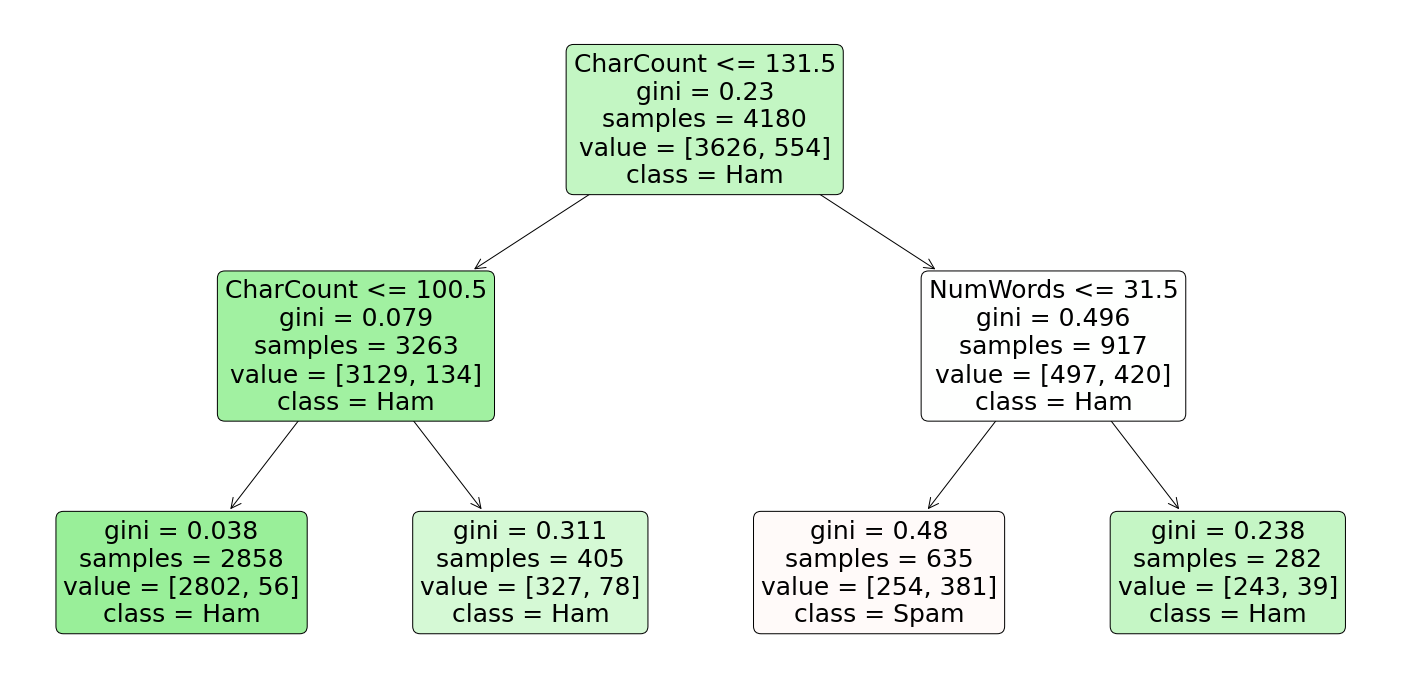

In [78]:
# Depth 2
metrics_2 = genDecTree(2, x_train, x_test, y_train, y_test)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9090909090909091
Classification Precision 	:

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.906025824964132

TPR Train:	 0.5469314079422383
TNR Train:	 0.9644236072807502
FPR Train:	 0.03557639271924986
FNR Train:	 0.45306859205776173

TPR Test:	 0.5284974093264249
TNR Test:	 0.9666944213155704
FPR Test:	 0.03330557868442964
FNR Test:	 0.47150259067357514


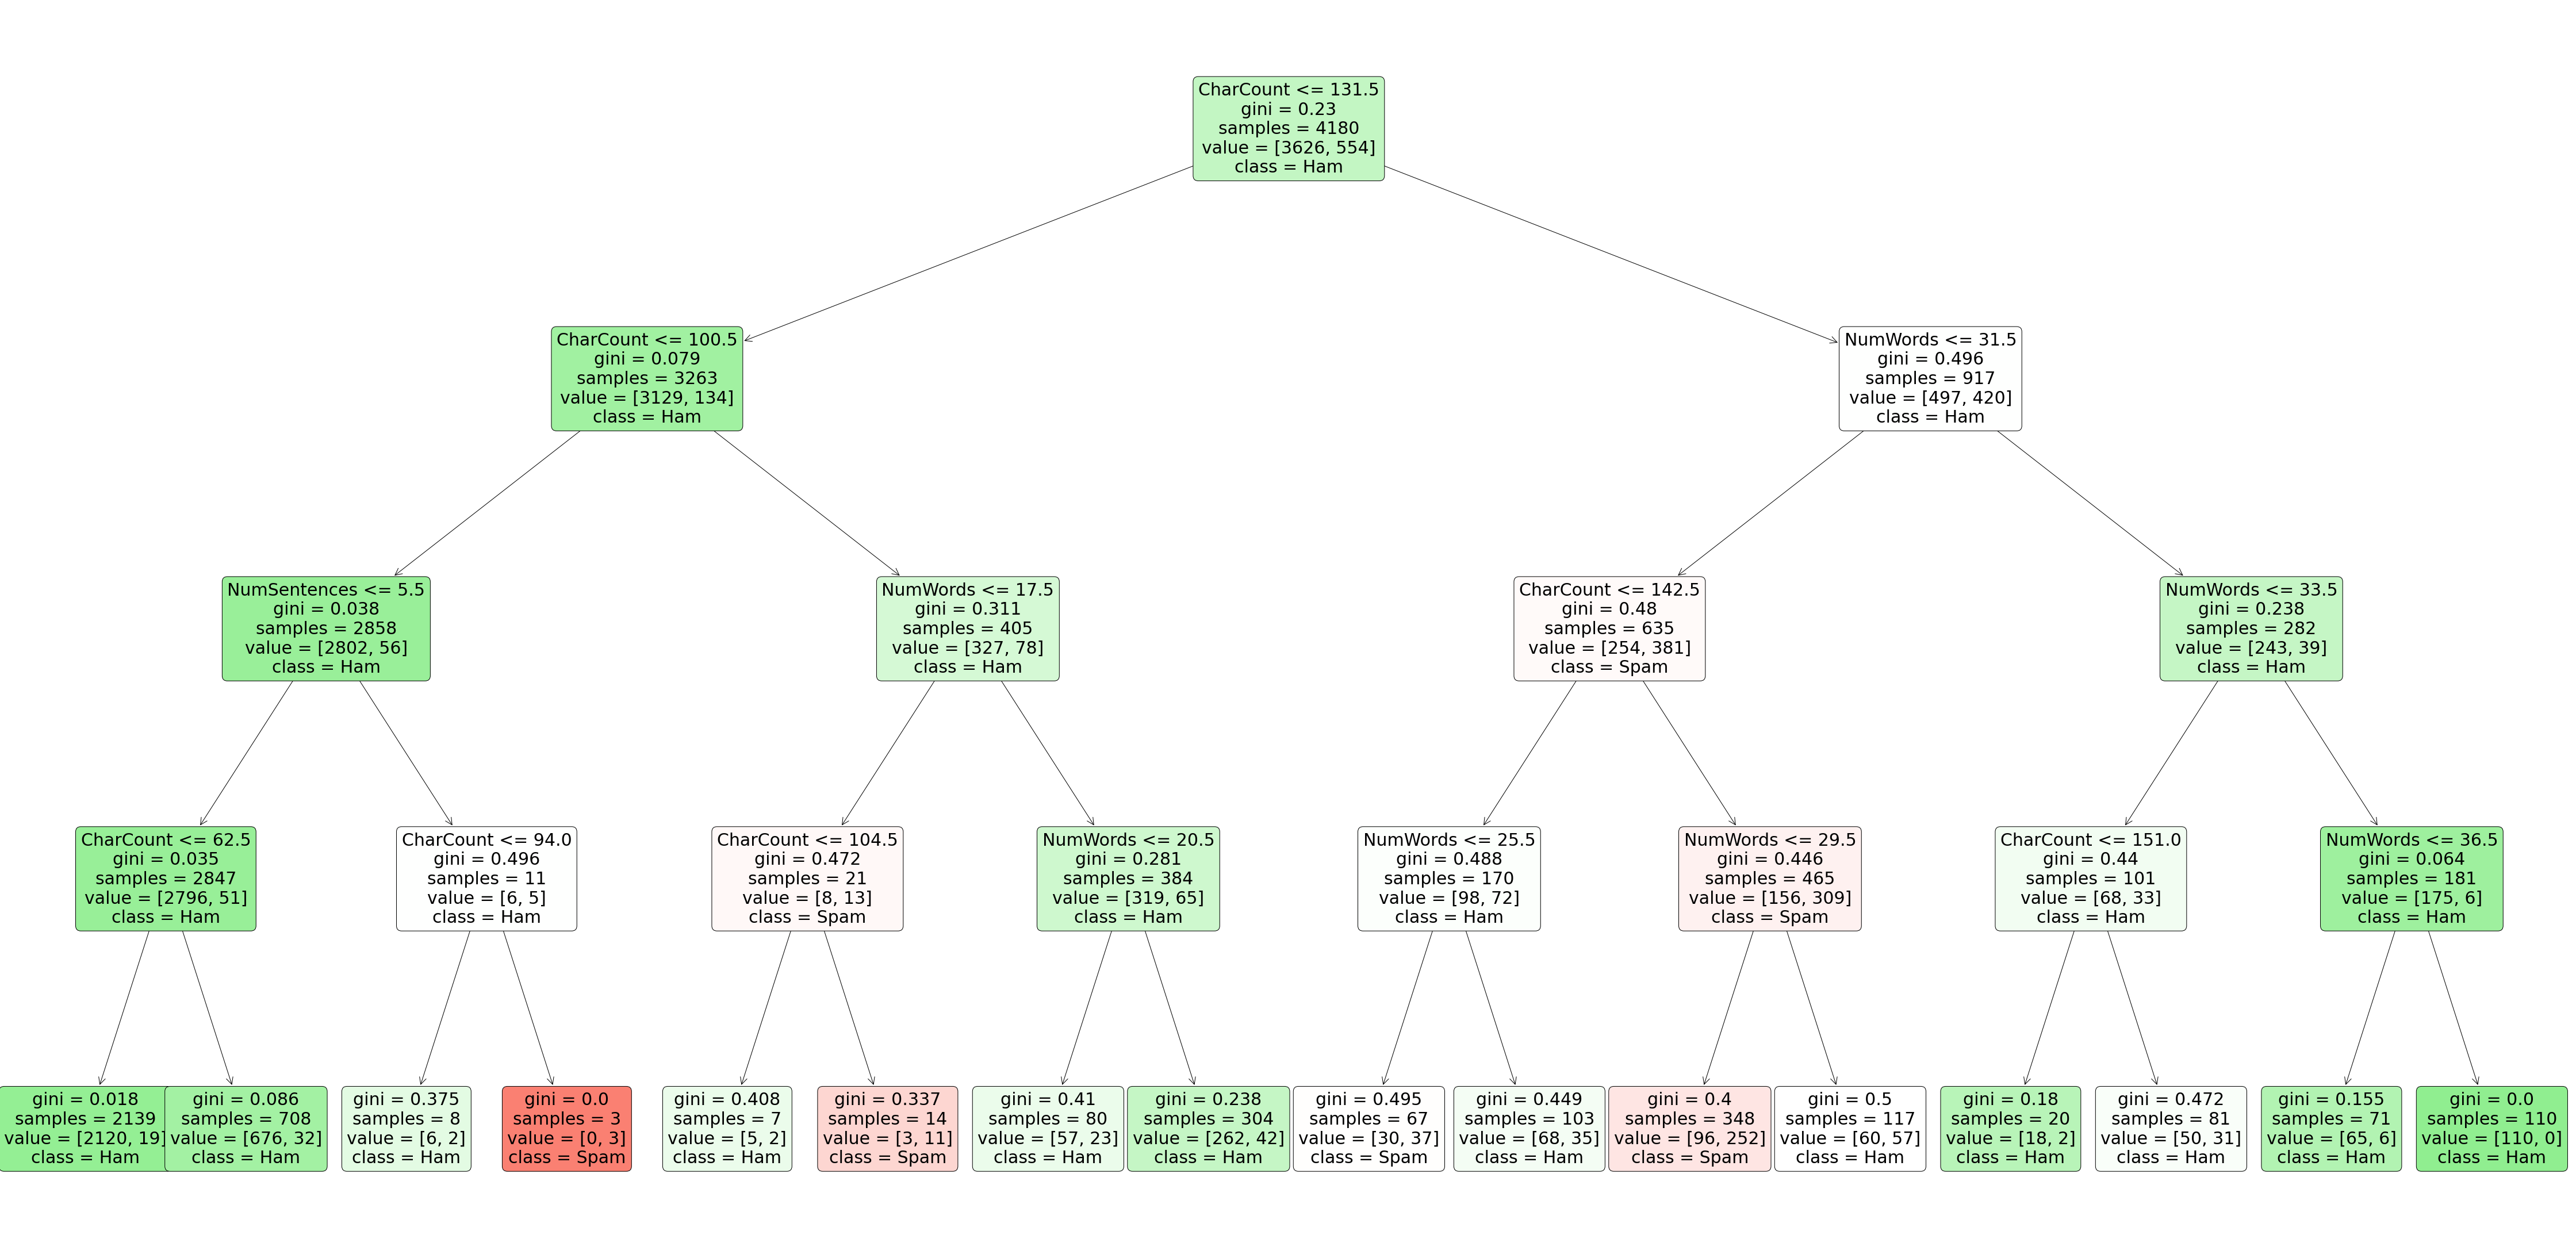

In [79]:
# Depth 4
metrics_4 = genDecTree(4, x_train, x_test, y_train, y_test)

In [80]:
# Depth 6
metrics_6 = genDecTree(6, x_train, x_test, y_train, y_test)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9169856459330143
Classification Precision 	:

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.9010043041606887

TPR Train:	 0.6101083032490975
TNR Train:	 0.9638720353006067
FPR Train:	 0.03612796469939327
FNR Train:	 0.3898916967509025

TPR Test:	 0.5181347150259067
TNR Test:	 0.9625312239800167
FPR Test:	 0.03746877601998335
FNR Test:	 0.48186528497409326


In [81]:
# Depth 10
metrics_10 = genDecTree(10, x_train, x_test, y_train, y_test)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9485645933014354
Classification Precision 	:

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.900286944045911

TPR Train:	 0.740072202166065
TNR Train:	 0.980419194704909
FPR Train:	 0.01958080529509101
FNR Train:	 0.259927797833935

TPR Test:	 0.616580310880829
TNR Test:	 0.9458784346378019
FPR Test:	 0.05412156536219817
FNR Test:	 0.38341968911917096


In [82]:
# Depth 4 F1-score
def get_f1_score(metrics):
    (tpr_train, tnr_train, fpr_train, fnr_train), (tpr_test, tnr_test, fpr_test, fnr_test) = metrics
    precision_train = tpr_train / (tpr_train + fpr_train)
    recall_train = tpr_train/(tpr_train + fnr_train)
    f1_train = 2 * ((precision_train * recall_train) / (precision_train + recall_train))
    print("F1 Train:\t", f1_train)
    precision_test = tpr_test / (tpr_test + fpr_test)
    recall_test = tpr_test/(tpr_test + fnr_test)
    f1_test = ((precision_test * recall_test) / (precision_test + recall_test))
    print("F1 Test:\t", f1_test)
    return f1_train, f1_test

get_f1_score(metrics_4)

F1 Train:	 0.6912211209494462
F1 Test:	 0.33838929326132894


(0.6912211209494462, 0.33838929326132894)

**GO FOR THE TRANSFORMER MODEL (CUSTOM)**
- attention based models (idea of attention): good for named entity recognition: useful for spam ham bcos spam has less contextual info and more typos than ham msgs
- Embedding Layer
- Encoder (positional encoding: pos where text appears): LSTM  -> attention based model -> LSTM Layers
- Batch normalization layer (added-norms)
- Fully connected Dense Layer (added-norms: output of dense + output of 1st dense layer)
- Decoder: Output embeedings -> boolean mask attention model -> addition normalization layer --> 2nd multi-head attention layer -> linear -> softmax

# Feature Processing

### Create Tokenizer Function

In [83]:
def get_word_idx(_df, col_name):
    def _fn():
        _word_idx = {}
        _count = 1
        for idx, row in _df[col_name].iteritems():
            # print(f"row: {row}")
            for word in row:
                if word not in _word_idx.keys():
                    _word_idx[word] = _count
                    _count += 1

        return _word_idx

    if not os.path.isfile(word_idx_json): # json cached word idx file does not exist, thus get file
        word_idx = _fn()

        # write to json file
        with open(word_idx_json, 'w') as outfile:
            json.dump(word_idx, outfile, indent=4)

    else: # json file found, read json file into word_idx dict
        with open(word_idx_json, 'r') as openfile:
            word_idx = json.load(openfile)

    return word_idx

In [84]:
word_idx_dict = get_word_idx(df, 'ListWords')
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False, filters=[])
tokenizer.word_index = word_idx_dict


### Tokenize Messages

In [85]:
df['TokenizedMsg'] = tokenizer.texts_to_sequences(df['Msg'].to_list())
df.head()

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences,Ham,Spam,id,TokenizedMsg
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point, ,, crazy, .., Avail...",20,"[Go until jurong point, crazy, Available only ...",3,3.0,NaN,1,"[1, 2, 3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19..."
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]",6,"[Ok lar, Joking wif u oni]",2,2.0,NaN,2,"[24, 26, 27, 28]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",29,[Free entry in 2 a wkly comp to win FA Cup fin...,2,NaN,2.0,3,"[30, 31, 10, 32, 33, 34, 35, 36, 37, 38, 39, 4..."
3,ham,U dun say so early hor... U c already then say...,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...",11,"[U dun say so early hor, U c already then say]",2,2.0,NaN,4,"[56, 57, 58, 59, 60, 56, 62, 63, 64]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, don't, think, he, goes, to, usf, ,, h...",13,"[Nah I don't think he goes to usf, he lives ar...",1,1.0,NaN,5,"[65, 66, 67, 68, 69, 70, 36, 69, 72, 73, 74, 75]"


In [86]:
# Pad Sequences
"""We are padding to length 39, since 39 is the max length for spam msgs and 37 is the upper fence for our ham msgs, meaning most msgs should fall within 39 words"""

print(df['TokenizedMsg'].to_list())
padded_seq = tf.keras.preprocessing.sequence.pad_sequences(df['TokenizedMsg'].to_list(), maxlen=39)

count = 0

df['PaddedMsgs'] = [[] for x in range(len(padded_seq))]

for idx, row in df.iterrows():
    for s in padded_seq[idx]:
        row['PaddedMsgs'].append(s)

df.head()

[[1, 2, 3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22], [24, 26, 27, 28], [30, 31, 10, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46, 38, 36, 47, 36, 48, 31, 49, 50, 54, 55], [56, 57, 58, 59, 60, 56, 62, 63, 64], [65, 66, 67, 68, 69, 70, 36, 69, 72, 73, 74, 75], [76, 77, 20, 78, 79, 80, 81, 82, 83, 84, 85, 86, 89, 90, 91, 92, 93, 94, 95, 96, 99, 101, 102, 103, 36, 36, 107], [108, 109, 110, 111, 112, 90, 36, 113, 114, 2198, 116, 117, 115, 90, 118], [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 80, 131, 132, 122, 133, 95, 134, 136, 137, 36, 138, 122, 139, 140], [120, 33, 143, 144, 145, 93, 146, 80, 147, 36, 148, 149, 150, 152, 153, 154, 156, 157, 159, 160, 161], [162, 122, 163, 164, 165, 166, 56, 168, 169, 36, 170, 36, 171, 172, 173, 174, 114, 175, 95, 176, 177, 178, 170, 179, 180, 181, 182], [183, 184, 185, 186, 187, 84, 188, 67, 189, 36, 190, 191, 192, 193, 194, 197, 198, 199, 9785], [201, 202, 36, 37, 204, 205, 36, 208, 210, 84, 104, 36, 212, 217, 218, 54, 219, 22

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences,Ham,Spam,id,TokenizedMsg,PaddedMsgs
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point, ,, crazy, .., Avail...",20,"[Go until jurong point, crazy, Available only ...",3,3.0,NaN,1,"[1, 2, 3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]",6,"[Ok lar, Joking wif u oni]",2,2.0,NaN,2,"[24, 26, 27, 28]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",29,[Free entry in 2 a wkly comp to win FA Cup fin...,2,NaN,2.0,3,"[30, 31, 10, 32, 33, 34, 35, 36, 37, 38, 39, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 31..."
3,ham,U dun say so early hor... U c already then say...,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...",11,"[U dun say so early hor, U c already then say]",2,2.0,NaN,4,"[56, 57, 58, 59, 60, 56, 62, 63, 64]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, don't, think, he, goes, to, usf, ,, h...",13,"[Nah I don't think he goes to usf, he lives ar...",1,1.0,NaN,5,"[65, 66, 67, 68, 69, 70, 36, 69, 72, 73, 74, 75]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Update Train & Tests with current cols

### Check train-test split shape pre-merge

In [87]:
#TODO: Match rows in paddedMsgs to split train test datasets
print(f'x_train count: {len(x_train.index)}')
print(f'y_train count: {len(y_train.index)}')
print(f'x_test count: {len(x_test.index)}')
print(f'y_test count: {len(y_test.index)}')

x_train count: 4180
y_train count: 4180
x_test count: 1394
y_test count: 1394


### Merge train & test dfs with updated df

In [88]:
x_train = pd.merge(df, x_train, on=['CharCount', 'NumWords', 'NumSentences', 'id'], how='right')
x_test = pd.merge(df, x_test, on=['CharCount', 'NumWords', 'NumSentences', 'id'], how='right')

### Verify Shape did not change post-merge

In [89]:
print(f'x_train count: {len(x_train.index)}')
print(f'y_train count: {len(y_train.index)}')
print(f'x_test count: {len(x_test.index)}')
print(f'y_test count: {len(y_test.index)}')

x_train count: 4180
y_train count: 4180
x_test count: 1394
y_test count: 1394


In [90]:
x_train.head()

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences,Ham,Spam,id,TokenizedMsg,PaddedMsgs
0,ham,I'm done...,11,"[I'm, done, ...]",2,[I'm done],1,1.0,NaN,2098,[183],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ham,Wewa is 130. Iriver 255. All 128 mb.,36,"[Wewa, is, 130, ., Iriver, 255, ., All, 128, m...",8,"[Wewa is 130, Iriver 255, All 128 mb]",3,3.0,NaN,4679,"[10971, 111, 10973, 1794, 10975]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ham,I know girls always safe and selfish know i go...,77,"[I, know, girls, always, safe, and, selfish, k...",16,[I know girls always safe and selfish know i g...,3,3.0,NaN,3318,"[66, 396, 4718, 374, 1253, 84, 8992, 396, 188,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ham,Me fine..absolutly fine,23,"[Me, fine, .., absolutly, fine]",4,"[Me fine, absolutly fine]",2,2.0,NaN,5206,"[2750, 976]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,ham,When are you going to ride your bike?,37,"[When, are, you, going, to, ride, your, bike, ...",9,[When are you going to ride your bike],1,1.0,NaN,469,"[867, 563, 93, 330, 36, 581, 122]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [91]:
x_test.head()

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences,Ham,Spam,id,TokenizedMsg,PaddedMsgs
0,ham,If you r @ home then come down within 5 min,43,"[If, you, r, @, home, then, come, down, within...",10,[If you r @ home then come down within 5 min],1,1.0,NaN,2370,"[460, 93, 1818, 625, 186, 64, 673, 347, 2804, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ham,I am on the way to ur home,26,"[I, am, on, the, way, to, ur, home]",8,[I am on the way to ur home],1,1.0,NaN,3993,"[66, 534, 181, 171, 302, 36, 316, 186]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ham,Also fuck you and your family for going to rho...,132,"[Also, fuck, you, and, your, family, for, goin...",28,[Also fuck you and your family for going to rh...,1,1.0,NaN,5488,"[3734, 3753, 93, 84, 122, 3138, 95, 330, 36, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3734, 375..."
3,ham,So there's a ring that comes with the guys cos...,112,"[So, there's, a, ring, that, comes, with, the,...",21,[So there's a ring that comes with the guys co...,3,3.0,NaN,813,"[334, 397, 33, 2985, 327, 723, 114, 171, 1367,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,ham,Having lunch:)you are not in online?why?,40,"[Having, lunch:)you, are, not, in, online, ?, ...",8,"[Having lunch:)you are not in online, why]",2,2.0,NaN,558,"[2932, 2933, 563, 112, 10]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Create Word Vectorizer Fn using word vectors from GloVe

In [92]:
def get_word2embedding_map(): # loads word vectors from GloVe data file into a dictionary, with the coefficients in an np array for each word
    _embeddings_idx = {}
    with open(glove_300d, encoding="utf8") as _f:
        for _line in tqdm.tqdm(_f, "Reading GloVe"):
            word, coefs = _line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            _embeddings_idx[word] = coefs

    print(f"There are {len(_embeddings_idx)} word vectors.")
    return _embeddings_idx

In [93]:
def get_embedding_vectors(_tokenizer, _word2embedding_map, _embedding_size):
    word_index = _tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, _embedding_size)) # initializes all cells of matrix to 0
    for word, i in word_index.items():
        embedding_vector = _word2embedding_map.get(word) # gets embedding vector for word
        if embedding_vector is not None:
            # words not found will remain as 0s
            embedding_matrix[i] = embedding_vector # assigns matrix for words found
    return embedding_matrix

### Set up Embedding Index

In [94]:
word2embedding_map = get_word2embedding_map()

Reading GloVe: 400000it [01:07, 5914.52it/s]

There are 400000 word vectors.


# Format Inputs for Model

### Format features

In [95]:
_x_train = np.array(x_train['PaddedMsgs'].to_list())
_x_test = np.array(x_test['PaddedMsgs'].to_list())

print(_x_train[0])
print(_x_test[0])
print(type(_x_train))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0 183]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  460   93 1818  625  186   64  673  347 2804 1039 1007]
<class 'numpy.ndarray'>


### One-Hot encode labels

In [96]:
label2int = {"ham": 0, "spam": 1}

_y_train = []
_y_test = []

for idx, row in y_train.iterrows():
    _y_train.append(label2int[row['Type']])

for idx, row in y_test.iterrows():
    _y_test.append(label2int[row['Type']])

_y_train = tf.keras.utils.to_categorical(_y_train)
_y_test = tf.keras.utils.to_categorical(_y_test)

print(type(_x_train))
print(type(_x_test))
print(type(_y_train))
print(type(_y_test))

print(_y_train[0])

print(_x_train.shape)
print(_x_test.shape)
print(_y_train.shape)
print(_y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[1. 0.]
(4180, 39)
(1394, 39)
(4180, 2)
(1394, 2)


# Generate Model

In [97]:
class LSTMModel(tf.keras.Model):
    def __init__(self, sequence_length, lstm_units, _tokenizer, _word2embedding_map, _embedding_size, _embedding_matrix, _activation):
        super(LSTMModel, self).__init__()
        self.inputs = tf.keras.layers.InputLayer()
        self.embedding = tf.keras.layers.Embedding(
            input_dim=len(_tokenizer.word_index)+1,
            weights=[_embedding_matrix],
            trainable=False,
            input_length=sequence_length,
            output_dim=_embedding_size
        )
        self.lstm = tf.keras.layers.LSTM(units=lstm_units, recurrent_dropout=0.2, kernel_initializer=tf.keras.initializers.GlorotUniform())
        self.dropout = tf.keras.layers.Dropout(rate=0.3)
        self.dense = tf.keras.layers.Dense(units=2, activation=_activation)

    def call(self, inputs):
        _input = self.inputs(inputs)
        _embed = self.embedding(_input)
        _lstm = self.lstm(_embed)
        _dropout = self.dropout(_lstm)
        _output = self.dense(_dropout)  # output
        return _output

In [98]:
"""class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(**kwargs)
        self.f1_score = self.add_weight(name='f1', initializer='zeros')
        self.precision = tf.keras.metrics.Precision
        self.recall = tf.keras.metrics.Recall

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision = self.precision(y_true, y_pred)
        self.recall = self.recall(y_true, y_pred)
        f1 = (2 * self.precision * self.recall) / (self.precision + self.recall)

        self.f1_score.assign_add(f1)

    def result(self):
        return self.f1_score

    def reset_states(self):
        self.precision = 0
        self.recall = 0"""

"""
def get_f1(y_true, y_pred):

    conf_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)
    tn = conf_matrix[0][0]
    tp = conf_matrix[1][1]
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]

    if tp + fp == 0:
        precision = 1
        precision = tf.cast(precision, dtype=tf.float64)
        print(f"precision if dtype: {precision.dtype}")

    else:
        precision = tp / (tp + fp)
        precision = tf.cast(precision, dtype=tf.float64)


    if fn + tp == 0:
        recall = 1
        recall = tf.cast(recall, dtype=tf.float64)
    else:
        recall = tp / (tp + fn)
        recall = tf.cast(recall, dtype=tf.float64)

    f1_val = 2.00 * (precision * recall)/(precision + recall)

    return f1_val
"""

#"""

"""class F1Score(tf.keras.metrics.Metric):
    def __init__(self, num_classes=1, **kwargs):
        super(F1Score,self).__init__(name='F1Score',**kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")

    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm = self.confusion_matrix(y_true,y_pred)
        return self.total_cm

    def result(self):
        return self.process_confusion_matrix()

    def confusion_matrix(self,y_true, y_pred):

        # Make a confusion matrix

        y_pred = tf.argmax(y_pred,1)

        cm = tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm

    def process_confusion_matrix(self):
        "returns precision, recall and f1 along with overall accuracy"
        cm = self.total_cm
        diag_part = tf.linalg.diag_part(cm)
        precision = diag_part / (tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall = diag_part / (tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1 = 2 * precision * recall / (precision + recall + tf.constant(1e-15))
        return f1
"""

def f1(y_true, y_pred):
    def recall_m(_y_true, _y_pred):
        tp = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(_y_true * _y_pred, 0, 1)))
        positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(_y_true, 0, 1)))

        _recall = tp / (positives + tf.keras.backend.epsilon())
        return _recall


    def precision_m(_y_true, _y_pred):
        tp = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(_y_true * _y_pred, 0, 1)))
        pred_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(_y_pred, 0, 1)))

        _precision = tp / (pred_positives + tf.keras.backend.epsilon())
        return _precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))


In [99]:
def compile_and_fit_lstm(_tokenizer, _word2embedding_map, hyper_param_dict={}):

    # default values for hyperparams
    sequence_length=39
    _embedding_size=300
    lstm_units=128
    _optimizer='adam'
    _loss='binary_crossentropy'
    _accuracy='binary_accuracy'
    _epochs = 10
    _batch_size = 64
    _activation = 'sigmoid'

    # change hyperparams if supplied via hyper_param_dict
    if 'tokenizer' in hyper_param_dict:
        _tokenizer = hyper_param_dict['tokenizer']
    if 'sequence_length' in hyper_param_dict:
        sequence_length = hyper_param_dict['sequence_length']
    """if 'input_shape' in hyper_param_dict:
        input_shape = hyper_param_dict['input_shape']"""
    if 'embedding_size' in hyper_param_dict:
        _embedding_size = hyper_param_dict['embedding_size']
    if 'accuracy' in hyper_param_dict:
        _accuracy = hyper_param_dict['accuracy']
    _embedding_matrix = get_embedding_vectors(_tokenizer, _word2embedding_map, _embedding_size)

    # constructs the model, defaults to 128 LSTM units
    _lstm = LSTMModel(
        _tokenizer=_tokenizer,
        lstm_units=lstm_units,
        _word2embedding_map=_word2embedding_map,
        sequence_length=sequence_length,
        _embedding_size=_embedding_size,
        _embedding_matrix = _embedding_matrix,
        _activation=_activation
    )

    if 'optimizer' in hyper_param_dict:
        _optimizer = hyper_param_dict['optimizer']
    if 'loss' in hyper_param_dict:
        _loss = hyper_param_dict['loss']
    if 'epochs' in hyper_param_dict:
        _epochs = hyper_param_dict['epochs']
    if 'batch_size' in hyper_param_dict:
        _batch_size = hyper_param_dict['batch_size']

    _lstm.compile(
        optimizer=_optimizer,
        loss=_loss,
        metrics=[_accuracy, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1]  # maybe define custom f1 score (taking in both precision and recall)
    )

    # initialize our TensorBoard callback for better visualization
    tensorboard = tf.keras.callbacks.TensorBoard(f"logs/spam_classifier_{time.time()}")

    # Clear backend
    tf.keras.backend.clear_session()

    # train the model
    _lstm.fit(_x_train,
             _y_train,
             validation_data=(_x_test, _y_test),
             batch_size=_batch_size,
             epochs=_epochs,
             callbacks=[tensorboard],
             verbose=1)
    _lstm.save(results_folder / f'lstm_model_{_optimizer}_opt_{_loss}_loss_{_epochs}_epochs_{_embedding_size}_embedSize_{_batch_size}_batchSize')

    return _lstm

In [100]:
def eval_model(_model):
    # get the loss and metrics
    result = _model.evaluate(_x_test, _y_test)

    # extract metrics
    loss = result[0]
    accuracy = result[1]
    precision = result[2]
    recall = result[3]
    f1_score = result[4]

    print(f"results: {result}")

    # print metrics
    print(f"[+] Loss:   {loss*100:.2f}%")
    print(f"[+] Accuracy: {accuracy*100:.2f}%")
    print(f"[+] Precision:   {precision*100:.2f}%")
    print(f"[+] Recall:   {recall*100:.2f}%")
    print(f"[+] F1 Score:   {f1_score*100:.2f}%")

In [101]:
if not os.path.isdir(results_notebook):
        os.makedirs(results_notebook)

rebuild_model = False

dir_lst = glob.glob(str(results_notebook / 'lstm_model**/'))

hyper_params = {'epochs': 10, 'optimizer': 'rmsprop'}

if not dir_lst or rebuild_model:
    lstm = compile_and_fit_lstm(tokenizer, word2embedding_map, hyper_param_dict=hyper_params)
else:
    dir_lst.sort(key=os.path.getmtime)
    to_load = dir_lst[-1]
    lstm = tf.keras.models.load_model(to_load, custom_objects={'f1': f1})
    print(f"Loaded {to_load}")

eval_model(lstm)

Epoch 1/10
66/66 [==============================] - 36s 497ms/step - loss: 0.2211 - binary_accuracy: 0.9234 - precision: 0.9247 - recall: 0.9220 - f1: 0.9224 - val_loss: 0.1348 - val_binary_accuracy: 0.9505 - val_precision: 0.9499 - val_recall: 0.9512 - val_f1: 0.9506
Epoch 2/10
66/66 [==============================] - 32s 488ms/step - loss: 0.1243 - binary_accuracy: 0.9575 - precision: 0.9579 - recall: 0.9572 - f1: 0.9574 - val_loss: 0.0955 - val_binary_accuracy: 0.9670 - val_precision: 0.9663 - val_recall: 0.9677 - val_f1: 0.9669
Epoch 3/10
66/66 [==============================] - 33s 494ms/step - loss: 0.0999 - binary_accuracy: 0.9663 - precision: 0.9656 - recall: 0.9670 - f1: 0.9667 - val_loss: 0.0853 - val_binary_accuracy: 0.9702 - val_precision: 0.9699 - val_recall: 0.9706 - val_f1: 0.9701
Epoch 4/10
66/66 [==============================] - 32s 492ms/step - loss: 0.0802 - binary_accuracy: 0.9742 - precision: 0.9735 - recall: 0.9749 - f1: 0.9745 - val_loss: 0.0810 - val_binary_acc

INFO:tensorflow:Assets written to: D:\GitHub\SC1015-NLP-Spam-Detection-Project\data\results\lstm_model_rmsprop_opt_binary_crossentropy_loss_10_epochs_300_embedSize_64_batchSize\assets


44/44 [==============================] - 3s 58ms/step - loss: 0.1344 - binary_accuracy: 0.9652 - precision: 0.9649 - recall: 0.9656 - f1: 0.9656
results: [0.13441148400306702, 0.9652080535888672, 0.9648745656013489, 0.9655666947364807, 0.9655594229698181]
[+] Loss:   13.44%
[+] Accuracy: 96.52%
[+] Precision:   96.49%
[+] Recall:   96.56%
[+] F1 Score:   96.56%


In [102]:
def get_predictions(_msg, _tokenizer, _model):
    if _msg != '':
        sequence = tokenizer.texts_to_sequences([_msg])

        seq_length = 39

        # pad the sequence
        sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=seq_length)

        sequence = np.array(sequence)

        # get the prediction
        prediction = _model.predict(sequence)

        # decode one-hot encoded vector
        int2label = {0: 'Ham', 1: 'Spam'}
        return int2label[np.argmax(prediction)]
    else:
        return 'EmptyMsg'

In [105]:
predict_text = [
                # Spam
                'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest',
                'Netflix is sending you a refund of $12.99. Please reply with your bank account and routing number to verify and get your refund',
                'Your account is temporarily frozen. Please log in to to secure your account ',
                'You won a prize of 1,000$, click here to claim!',
                'Beautiful weekend coming up. Wanna go out? Sophie gave me your number. Check out my profile here: bit.ly/profileGB12RD',
                'Dear customer, Bank of America is closing your bank account. Please confirm your PIN at notbankofamerica.com/XJY23VB to keep your account activated.',
                 "You've won a prize! Go to bit.ly/yourprize001 to claim your $500 Amazon gift card",

                #ham
                'The article was published on 18th August itself',
                'Although we are unable to give you an exact time-frame at the moment, I would request you to stay tuned for any updates.',
                'The image you sent is a UI bug, I can check that your article is marked as regular and is not in the monetization program.',
                'Hello I am Jerome.'
]

for m in predict_text:
    r = get_predictions(_msg=m, _tokenizer=tokenizer, _model=lstm)
    print(f"{r}: '{m}'")

Ham: 'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest'
Spam: 'Netflix is sending you a refund of $12.99. Please reply with your bank account and routing number to verify and get your refund'
Ham: 'Your account is temporarily frozen. Please log in to to secure your account '
Spam: 'You won a prize of 1,000$, click here to claim!'
Ham: 'Beautiful weekend coming up. Wanna go out? Sophie gave me your number. Check out my profile here: bit.ly/profileGB12RD'
Ham: 'Dear customer, Bank of America is closing your bank account. Please confirm your PIN at notbankofamerica.com/XJY23VB to keep your account activated.'
Spam: 'You've won a prize! Go to bit.ly/yourprize001 to claim your $500 Amazon gift card'
Ham: 'The article was published on 18th August itself'
Ham: 'Although we are unable to give you an exact time-frame at the moment, I would request you to stay tuned for any updates.'
Ham: 'The image you 

It looks like from my tests:

GloVe 300 was the best dimensions, RMSprop was the best optimizer, Categorical CrossEntropy was the best loss fn, and epoch 17? (pls help verify for epoch) had the best f1 val metric

Can help talk abt how we run the python script containing this imported TrainValidate class directly due to better performance (each epoch in the jupyter notebook took 1.5min to train whereas in the script it took around 45s)

In [104]:
from LSTMModel import TrainValidate


lst_glove = [50, 100, 200, 300]
optimizer_lst = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
loss_lst = ['binary_crossentropy', 'categorical_crossentropy', 'poisson'] # sparse_categorical_crossentropy is not used

# Varying glove, keeping rest of hyper-params constant
for g in lst_glove:
    train_val = TrainValidate(
        embedding_map=word2embedding_map,
        glove_embedding_size=g,
        lstm_units=128,
        train=True,
    )

    train_val.compile_run(accuracy='accuracy',
        optimizer='adam',
        loss='binary_crossentropy',
        batch_size=64,
        epochs=10
)

# Varying optimizer, keeping rest of hyper-params constant
for o in optimizer_lst:
    train_val = TrainValidate(
        embedding_map=word2embedding_map,
        glove_embedding_size=300,
        lstm_units=128,
        train=True,
    )

    train_val.compile_run(accuracy='accuracy',
        optimizer=o,
        loss='binary_crossentropy',
        batch_size=64,
        epochs=10
)

# Varying loss, keeping rest of hyper-params constant
for l in loss_lst:
    train_val = TrainValidate(
        embedding_map=word2embedding_map,
        glove_embedding_size=300,
        lstm_units=128,
        train=True,
    )

    train_val.compile_run(accuracy='accuracy',
        optimizer='adam',
        loss=l,
        batch_size=64,
        epochs=10
)

    if l == 'poisson':
        train_val.eval_models()
        train_val.load_histories()

"""train_val = TrainValidate(
        embedding_map=word2embedding_map,
        glove_embedding_size=300,
        lstm_units=128
    )

for o in optimizer_lst:

        for l in lost_lst:
            train_val.compile_run(accuracy='accuracy',
                                  optimizer=o,
                                  loss=l,
                                  batch_size=64,
                                  epochs=10
                                  )"""

Epoch 1/10
66/66 [==============================] - 144s 2s/step - loss: 0.5403 - accuracy: 0.8589 - precision: 0.8396 - recall: 0.8467 - f1: 0.8445 - val_loss: 0.4690 - val_accuracy: 0.8558 - val_precision: 0.8563 - val_recall: 0.8551 - val_f1: 0.8560
Epoch 2/10
 8/66 [==>...........................] - ETA: 1:46 - loss: 0.4576 - accuracy: 0.8613 - precision: 0.8611 - recall: 0.8594 - f1: 0.8602

KeyboardInterrupt: 

In [ ]:
train_val = TrainValidate(
        embedding_map=word2embedding_map,
        glove_embedding_size=300,
        lstm_units=128
)

train_val.eval_models()
train_val.load_history()